# Mapeo pro-bono: Prototipo 1
Este prototipo busca analizar el impacto de diferentes organizaciones del 3er sector sobre el area metropolitana de Monterrey. En este archivo se explica el proceso por el cual se realizo este mapeo.
## Importar dependencias
El prototipo depende de las librerias de _pandas_ y _geopandas_ para realizar el procseo de mapeo. Tambien se usan partes de la liberia estandar de Python como `re`, que es una libreria de expresiones regulares para facilitar la limpieza de datos.

In [77]:
import pandas as pd
import geopandas as gpd
import re

## Importar regiones geograficas
Los archivos `.shp` que se leen a continuacion contienen los AGEBS de cada municipio del Area Metropolitana de Monterrey, excluyendo aquellos que no contengan suficientes AGEBS para su analisis.

Se procede a limpiar el contenido de los archivos para asi terminar con una tabla completa de todos los AGEBS de la ciudad, cada uno con su respectivo codigo, asi como el nombre de su sector. Estos sectores son los definidos anteriormente por GeoSTATS.

In [78]:
regions = [
    gpd.read_file('../regions/Apodaca/AgebsDentrodeApodaca.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Escobedo/AgebsDentrodeEscobedo.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Garcia/AgebsDentrodeGarcia.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Juarez/AgebsDentrodeJuarez.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Monterrey/AgebsDentrodeMonterrey.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Nicolas/AgebsDentroSanNicolas.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Pedro/AgebsDentrodeSanPedro.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Santa Catarina/AgebsDentrodeSantaCatarina.shp').to_crs('WGS 84')
]

for region in regions:
    region.rename(columns={'Nombre': 'sector_name'}, inplace=True)

guadalupe = gpd.read_file('../regions/Guadalupe/Copia de GUADALUPESectores.shp').to_crs('WGS 84')
guadalupe.rename(columns={'Name': 'sector_name'}, inplace=True)
regions.append(guadalupe)

for region in regions:
    region.rename(columns={'clave': 'code'}, inplace=True)

agebs = gpd.GeoDataFrame(
    pd.concat(regions, ignore_index=True) \
        .filter(items=['sector_name', 'code', 'geometry'])
)
agebs

,sector_name,code,geometry
0,Metroplex,1900600010850,"POLYGON ((-100.25504 25.80534, -100.25483 25.8..."
1,Metroplex,1900600012081,"POLYGON ((-100.24877 25.79173, -100.24876 25.7..."
2,Metroplex,1900600010719,"POLYGON ((-100.25893 25.78469, -100.25843 25.7..."
3,Metroplex,1900600010901,"POLYGON ((-100.24887 25.78764, -100.24882 25.7..."
4,Metroplex,1900600011276,"POLYGON ((-100.25602 25.78718, -100.25600 25.7..."
...,...,...,...
3171,Los Faines,NaN,"POLYGON Z ((-100.18882 25.69060 0.00000, -100...."
3172,Polígono 28,NaN,"POLYGON Z ((-100.25274 25.67564 0.00000, -100...."
3173,Camino Real,NaN,"MULTIPOLYGON Z (((-100.22985 25.67113 0.00000,..."
3174,Unidad Modelo,NaN,"POLYGON Z ((-100.21046 25.69415 0.00000, -100...."


A continuación se muestra una visualización de todos los AGEBS, coloreados por el sector al cual pertenecen.

<Axes: >

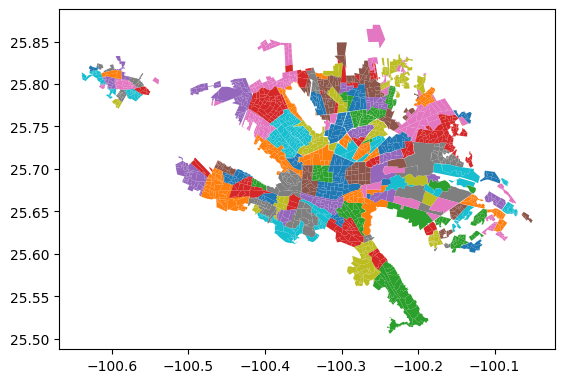

In [79]:
agebs.plot('sector_name')

## Cargar datos del formulario
El formulario de GeoSTATS contiene datos de cada organización que quiere incluirse a este proyecto, y contiene los sectores en los cuales esta organización esta activa. Asimismo, tambien contiene datos especificos por organización, como el ODS al cual atiende, sus niveles de personal, entre otros datos.

In [80]:
survey_answers = pd.read_csv('../respuestas_formulario.csv')
survey_answers.rename(columns={
    '1. Nombre de la organización/colectivo/iniciativa:': 'name',
    '3. Coloca el año en que la organización se constituyó legalmente en Nuevo León': 'legal_incorporation_year',
    '10. Coloca el año en que comenzaron sus actividades en Nuevo León: (independiente de tu año de constitución legal)': 'start_of_operations_year',
    '2. Selecciona el rango aproximado de ingresos totales que obtuvo tu organización/colectivo/iniciativa (incluyendo donativos y otros tipos de ingreso) en el último año aplicable inmediato (en pesos)': 'annual_income',
    '1. Selecciona el número de integrantes con nómina o remunerados económicamente con los que cuenta tu organización/colectivo/iniciativa al día de hoy:': 'employee_count',
    '2. Selecciona el número de personas voluntarias totales (recurrentes o esporádicos) que tu organización/colectivo/iniciativa tuvo en el año 2022:': 'volunteer_count',
    '3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 1. Fin de la pobreza.]': 'ods',
    '4. Indica cuáles son las 3 principales actividades que realiza tu organización/colectivo/iniciativa': 'main_activities',
    'Indica cuál es el grupo de población objetivo (beneficiarios, usuarios) que atiende tu organización/colectivo/iniciativa. Puedes utilizar un máximo de 5-6 opciones para ser lo más específico posible:': 'target_demographics',
}, inplace=True)
survey_answers = survey_answers.dropna(subset='name')
survey_answers

,Marca temporal,1. Nombre(s),3. Apellido Materno,2. Apellido Paterno,4. Puesto actual en la organización/colectivo/iniciativa,5. Correo electrónico de contacto,6. Teléfono de contacto (fijo o móvil),name,1. Razón social de la organización/colectivo/iniciativa (coloca el nombre como aparece en tu Acta Constitutiva),Sobre tu constitución legal o denominación: \n1. Selecciona la manera que más se asemeja a cómo identificas a tu agrupación:\n,...,3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 15. Vida de ecosistemas terrestres.],"3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 16. Paz, justicia e instituciones solidas.]",3. Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [ODS 17. Alianzas para lograr los objetivos.],1. Área de Administración [Protocolos de difusión],3. Área de Legalidad [Asesoría para constitución legal],3. ¿Te encuentras constituida legalmente?,2. Coloca el año en que comenzaron sus actividades en Nuevo León: (independiente de tu año de constitución legal),2. ¿Es de tu interés constituirte legalmente?,Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [Fila 2],Indica a cuál Objetivo de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU contribuye tu organización/colectivo/iniciativa (solo una opción): [Fila 3]
1,19/11/2022 16:36:42,efren,cuenca,8a,a,aa@gmail.com,55555555,geostats,sa de cv,Comunidad de aprendizaje,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3/12/2022 16:11:58,Xochitl Marina,Ortiz,Mendoza,Líder de Evaluación y Monitoreo,xochitl.mendoza@tarahumara.org,8132557861,Fundación Tarahumara José A. Llaguno,Fundación Tarahumara José A. Llaguno,Organización de la sociedad civil,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3/12/2022 16:12:01,Florencia,Gonzalez,Garza,Direccion,florenciadelossantosmx@hotmail.com,8184666250,Laboratorio de Innovación Social Tutores de Re...,NaN,Organización de la sociedad civil,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3/12/2022 16:26:22,Gabriela,Sánchez,Charles,Directora operaciones,esperanzaaldebil@gmail.com,8116571440,Comedor Infantil Mensajero de Paz- Esperanza a...,Esperanza al Débil A.C.,Organización de la sociedad civil,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3/12/2022 16:01:34,Xochitl Marina,Mendoza,Ortiz,Dirección de Desarrollo de Capacidades,ecoaldeasdelnorte@gmail.com,832 55 78 61,Ecoaldeas del Norte,NaN,Colectivo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,25/2/2023 16:04:48,cas,sadf,adf,asdf,luisefrencuenasdsdca@gmail.com,9564454676,asdf,NaN,Laboratorio ciudadano,...,NaN,NaN,NaN,NaN,2.0,No,2015.0,No,NaN,NaN
11,2/5/2023 12:32:12,Mayela Isabel,Martínez,García,Procuración de fondos,recaudacion@amanec.org.mx,8113415073,AMANEC AC,AMANEC,Organización de la sociedad civil,...,NaN,NaN,NaN,NaN,NaN,Sí,1998.0,Sí,NaN,NaN
12,2/5/2023 14:02:51,Sara,Villarreal,De La Garza,Presidenta,saradelagarza13@gmail.com,8114148169,VIDA NUEVA SIN PSORIASIS ABP,VIDA NUEVA SIN PSORIASIS ABP,Organización de la sociedad civil,...,NaN,NaN,NaN,NaN,NaN,Sí,2008.0,No,NaN,NaN


A continuación se proceden a cargar estos datos, asi como generar dos tablas separadas: los datos por organización, y una tabla que contiene los sectores en los cuales cada organización esta operando. La siguiente tabla contiene todos los datos relevantes para una organización dada.

In [81]:
organizations = survey_answers.filter(
    items=['name', 'legal_incorportation_year', 'start_of_operations_year', 'annual_income', 'employee_count',
           'volunteer_count', 'ods', 'main_activities', 'target_demographics'])
organizations

,name,start_of_operations_year,annual_income,employee_count,volunteer_count,ods,main_activities,target_demographics
1,geostats,NaN,"Entre 500,001 a 1,000,000",1 a 5,6 a 10,"ODS 16. Paz, justicia e instituciones.","Salud, Educativas, Ecológicos, Apoyo económico","Niñas (6 a 11 años), Adolescentes hombres (15 ..."
6,Fundación Tarahumara José A. Llaguno,1992.0,NaN,21 a 50,21 a 50,ODS 4. Educación de calidad.,"Educativas, Apoyo económico, Desarrollo Social","Pre adolescentes mujeres (12 a 15 años), Pre a..."
7,Laboratorio de Innovación Social Tutores de Re...,2018.0,NaN,0,51 a 100,"ODS 16. Paz, justicia e instituciones.","Educativas, Investigación, Culturales (danza, ...","Primera infancia (0 a 5 años), Niños (6 a 11 a..."
8,Comedor Infantil Mensajero de Paz- Esperanza a...,2015.0,"Entre 500,001 a 1,000,000",6 a 10,Más de 250,ODS 2. Hambre cero.,"Asistenciales (Alimentación, vestido, vivienda...",Otros : Especificar lo más posible las caracte...
9,Ecoaldeas del Norte,2019.0,NaN,0,21 a 50,ODS 15. Vida de ecosistemas terrestres.,"Protección del medio ambiente, Ciencia y tecno...","Estudiantes, Familias, Animales salvajes, Anim..."
10,asdf,NaN,NaN,1 a 5,Más de 500,NaN,"Equidad y género, Deportivas, Reproducción de ...",NaN
11,AMANEC AC,NaN,"más de 5,000,000",6 a 10,101 a 250,NaN,"ASISTENCIALES, Promoción y aportación de servi...",NaN
12,VIDA NUEVA SIN PSORIASIS ABP,NaN,"Menos de 500,000",0,6 a 10,NaN,Promoción y aportación de servicios para la sa...,NaN


Finalmente, se consigue una relación entre las diferentes organizaciones y los sectores en donde estas operan.

In [84]:
municipalities = [
    'Apodaca',
    'Escobedo',
    'Garcia',
    'Guadalupe',
    'Juarez',
    'Monterrey',
    'San Nicolás de los Garza',
    'Santa Catarina',
    'San Pedro Garza García',
    'Agualeguas',
    'Allende',
    'Anahuac',
    'Aramberri',
    'Bustamante',
    'General Bravo',
    'Cerralvo',
    'Cienega',
    'China',
    'Dr Arroyo',
    'Dr. Coss',
    'Dr. Gonzalez',
    'El Carmen',
    'Abasolo',
    'Villaldama',
    'Hidalgo',
    'Gral Zuazua',
    'Gral. Zaragoza',
    'Gral Treviño',
    'Gral Terán',
    'Valecillo',
    'Santiago',
    'Salinas Victoria',
    'Sabinas Hidalgo',
    'Rayones',
    'Pesquería',
    'Parás',
    'Montemorelos',
    'Mina',
    'Mier y Noriega',
    'Melchor Ocampo',
    'Marín',
    'Los Ramones',
    'Las Herreras',
    'Los Aldamas',
    'Linares',
    'Lampazos',
    'Iturbide',
    'Hualahuises',
    'Galeana',
    'Cadereyta',
]

column_regex = re.compile(r'^.*\((.*)\)$')

def municipalities_filter(column: str):
    match = column_regex.match(column)
    if match is not None:
        return match.group(1) in municipalities
    else:
        return False


municipality_column_names = list(filter(
    municipalities_filter,
    survey_answers.columns))

organizations_with_regions = survey_answers.filter(items=municipality_column_names)

data = {'organization_name': [], 'sector_name': []}

for index, row in organizations_with_regions.iterrows():
    organization_name = organizations['name'][index]
    if not isinstance(organization_name, str):
        continue
    for value in row:
        if isinstance(value, str):
            sector_names = value.split(',')
            for sector_name in sector_names:
                data['organization_name'].append(organization_name)
                data['sector_name'].append(sector_name)

organization_region_names = pd.DataFrame(data=data)
organization_region_names


,organization_name,sector_name
0,geostats,Ebanos
1,geostats,Huinalá
2,geostats,Jardines de Primavera
3,geostats,Las Palmas
4,geostats,Mezquital
5,geostats,Sendero
6,geostats,Miravista
7,geostats,Acueducto
8,geostats,Oriente
9,Comedor Infantil Mensajero de Paz- Esperanza a...,Praderas de San Juan


<Axes: >

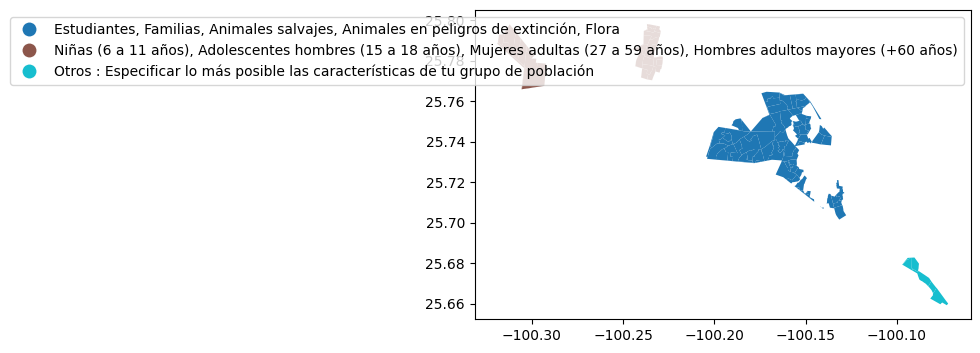

In [92]:
organization_regions = gpd.GeoDataFrame(
    organization_region_names.join(agebs.set_index('sector_name'), on='sector_name', how='left'))
organization_regions = gpd.GeoDataFrame(
    organization_regions.join(organizations.set_index('name'), on='organization_name', how='left')
)
organization_regions.plot('target_demographics', legend=True)